In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [2]:
import os
cur_dir = "/content/drive/MyDrive/mid-term"
os.chdir(cur_dir)
!ls -la .

total 265324
-rw------- 1 root root    409369 Dec 26 10:22 baseline2.ipynb
drwx------ 2 root root      4096 Dec 26 05:01 data
-rw------- 1 root root  30110922 Dec 18 15:59 fer2013_publictest_onehot.csv
-rw------- 1 root root 240958308 Dec 18 16:00 fer2013_training_onehot.csv
-rw------- 1 root root    207891 Dec 26 10:15 model.png


In [3]:
import zipfile

with zipfile.ZipFile('data/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Overview
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

# Import libraries

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from IPython.display import SVG
from tensorflow.keras.utils import plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [5]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# (1) Data

### Download data at https://www.kaggle.com/datasets/dntai1983/fer2013-onehot
This source code and npy files MUST be in the same location

In [7]:
n_inputs = 2304
n_classes = 7
img_dim = 48

trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [8]:

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

In [9]:
print("Training images: ", len(x_training), " - shape: ", x_training[0].shape)
print("Testing images: ", len(x_testing), " - shape: ", x_testing[0].shape)

Training images:  28709  - shape:  (2304,)
Testing images:  3589  - shape:  (2304,)


In [10]:
x_training.shape, y_training.shape

((28709, 2304), (28709, 7))

In [11]:
display(x_training[:3, :])
display(y_training[:3, :], np.argmax(y_training[:3, :], axis=1))

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.]])

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

array([0, 0, 2])

In [12]:
x_training = x_training.reshape(x_training.shape[0], 48, 48)
display(x_training.shape)
x_training = np.expand_dims(x_training, axis=3)
display(x_training.shape)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
display(x_testing.shape)
x_testing = np.expand_dims(x_testing, axis=3)
display(x_testing.shape)

(28709, 48, 48)

(28709, 48, 48, 1)

(3589, 48, 48)

(3589, 48, 48, 1)

In [13]:
y_train_labels = np.argmax(y_training, axis = 1)

In [14]:
emotion_names = np.array(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"])

In [15]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

<BarContainer object of 7 artists>

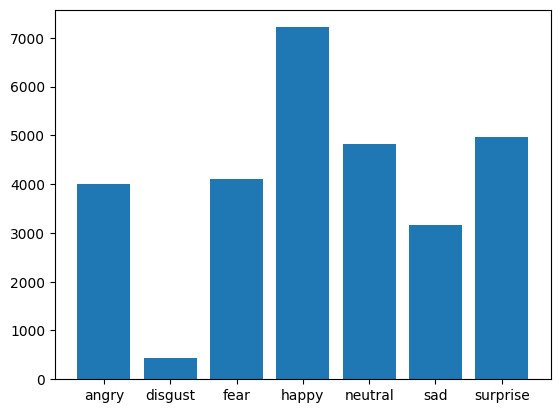

In [16]:
labels, cnts = np.unique(y_train_labels, return_counts=True)
plt.bar(emotion_names, cnts)

In [17]:
from sklearn.utils import class_weight

In [18]:
y_train_labels

array([0, 0, 2, ..., 4, 0, 4])

In [19]:
cnts / sum(cnts)

array([0.13915497, 0.01518688, 0.14270786, 0.25131492, 0.16823992,
       0.11045317, 0.17294228])

In [20]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=labels,
                                            y=y_train_labels)
weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.84912748,
       1.29337298, 0.82603942])

# (2) Declare model

In [21]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

Model: "emo_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 conv1_2 (Conv2D)            (None, 46, 46, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 23, 23, 64)        0         
                                                                 
 conv_dropout1 (Dropout)     (None, 23, 23, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 23, 23, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 21, 21, 128)       1475

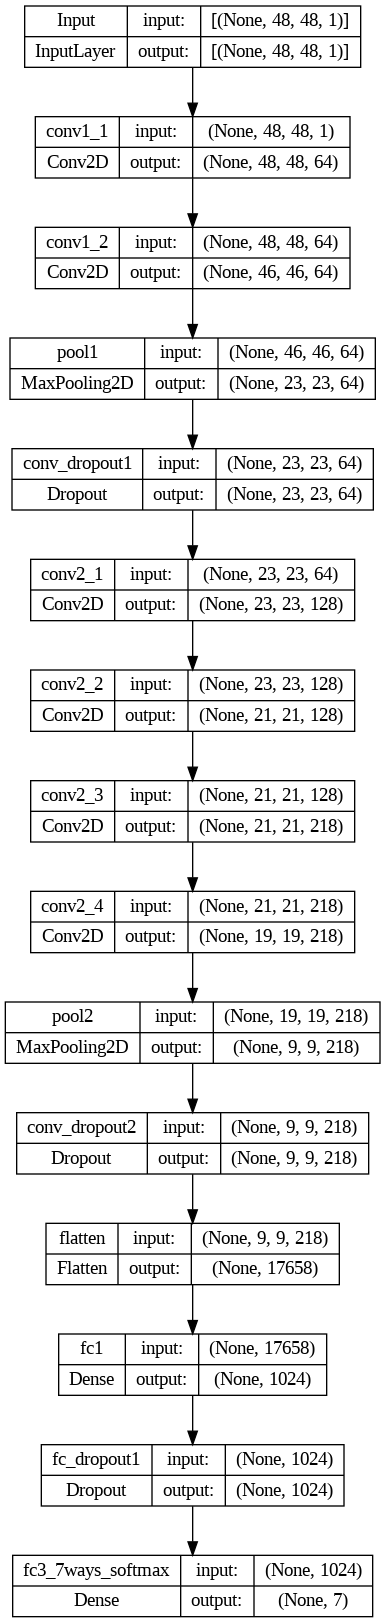

In [22]:
plot_model(model, to_file="model.png", show_shapes=True)

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

### **Training Run**

---
with learning_rate = 0.0001


In [23]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

In [24]:
# train the model
batch_size = 128
epochs = 15

starting_time = time.time()
h1 = model.fit(x_training, y_training,
                    validation_data=(x_testing, y_testing),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/15
225/225 [==============================] - 33s 100ms/step - loss: 2.0156 - accuracy: 0.2681 - val_loss: 1.6518 - val_accuracy: 0.3748
Epoch 2/15
225/225 [==============================] - 20s 90ms/step - loss: 1.6082 - accuracy: 0.3751 - val_loss: 1.4882 - val_accuracy: 0.4305
Epoch 3/15
225/225 [==============================] - 20s 91ms/step - loss: 1.4727 - accuracy: 0.4386 - val_loss: 1.3602 - val_accuracy: 0.4826
Epoch 4/15
225/225 [==============================] - 21s 91ms/step - loss: 1.3561 - accuracy: 0.4867 - val_loss: 1.2910 - val_accuracy: 0.5093
Epoch 5/15
225/225 [==============================] - 21s 92ms/step - loss: 1.2672 - accuracy: 0.5224 - val_loss: 1.2464 - val_accuracy: 0.5272
Epoch 6/15
225/225 [==============================] - 21s 94ms/step - loss: 1.1841 - accuracy: 0.5573 - val_loss: 1.2151 - val_accuracy: 0.5475
Epoch 7/15
225/225 [==============================] - 21s 94ms/step - loss: 1.0967 - accuracy: 0.5916 - val_loss: 1.1648 - val_accuracy

### **Result of The Training Run**

In [25]:
print("Training Run:")
print("Accuracy of the Testing Set: %.2f%%" % (h1.history['val_accuracy'][14]*100))

Training Run:
Accuracy of the Testing Set: 60.41%


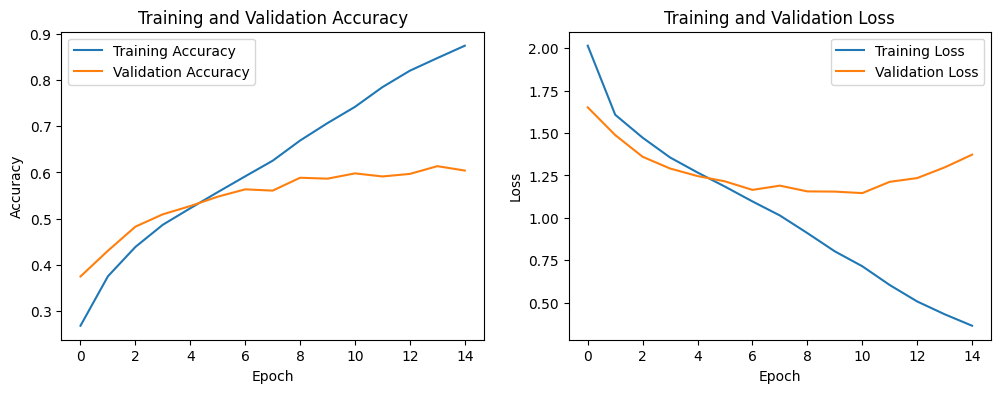

In [26]:
plot_history(h1)

In [27]:
import pandas as pd
pd.DataFrame(h1.history)

,loss,accuracy,val_loss,val_accuracy
0,2.015616,0.268069,1.651799,0.374756
1,1.608209,0.375144,1.488235,0.430482
2,1.472699,0.438643,1.360164,0.482586
3,1.356061,0.486711,1.290961,0.509334
4,1.267219,0.522415,1.246391,0.527166
5,1.184060,0.557317,1.215126,0.547506
6,1.096702,0.591557,1.164814,0.563388
7,1.013710,0.625309,1.189840,0.560602
8,0.909924,0.669059,1.155967,0.588465
9,0.802098,0.706851,1.154717,0.586514


### **Training time**
- Training time is about 6.3390 minutes for 15 epochs

# (4) Evaluate trained model

In [28]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

113/113 [==============================] - 1s 7ms/step - loss: 1.3727 - accuracy: 0.6041
Test loss: 1.372726321220398
Test accuracy: 0.6040679812431335


In [29]:
def get_emotion(ohv):
    indx = np.argmax(ohv)

    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

1/1 [==============================] - 0s 436ms/step


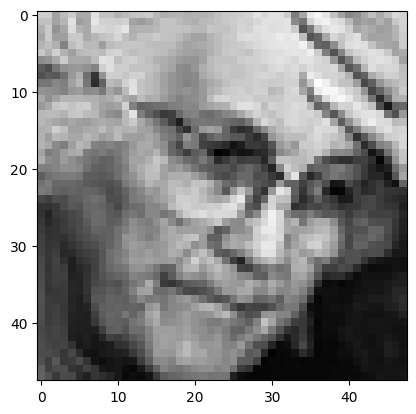

> testing image index: 2653
> true emotion: fear
> predicted emotion: fear


In [30]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

In [31]:
def predict_image(img_indx):
  sample = x_testing[img_indx, :]
  sample = sample.reshape(48, 48)

  pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

  plt.imshow(sample, cmap='gray')
  plt.show()
  print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))

In [32]:
y_test_pred = model.predict(x_testing)

113/113 [==============================] - 1s 6ms/step


In [33]:
y_test_pred_label = np.argmax(y_test_pred, axis = 1)
y_test_label = np.argmax(y_testing, axis=1)

**10 cases of incorrect predictions**

---

In [34]:
np.where(y_test_pred_label != y_test_label)

(array([   2,    7,    8, ..., 3586, 3587, 3588]),)

1/1 [==============================] - 0s 29ms/step


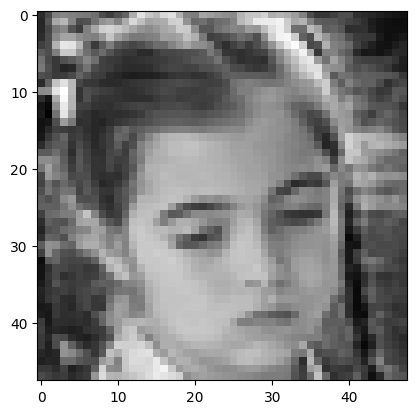

> testing image index: 2951
> true emotion: sad
> predicted emotion: happy
1/1 [==============================] - 0s 24ms/step


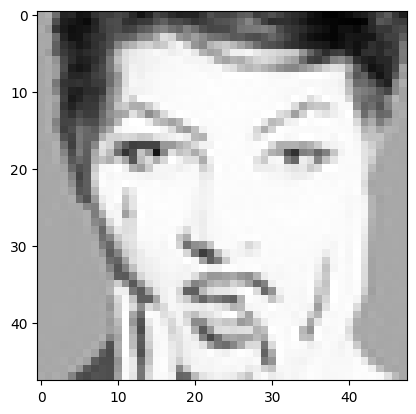

> testing image index: 608
> true emotion: sad
> predicted emotion: neutral
1/1 [==============================] - 0s 24ms/step


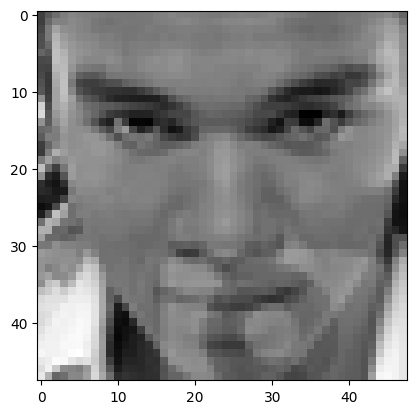

> testing image index: 2317
> true emotion: neutral
> predicted emotion: fear
1/1 [==============================] - 0s 25ms/step


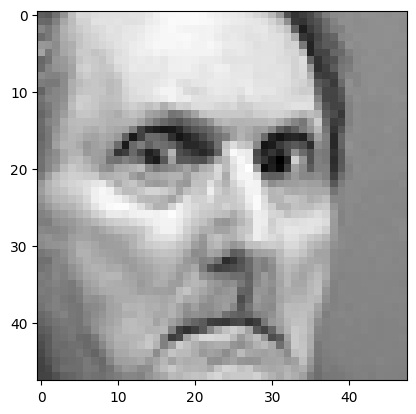

> testing image index: 3320
> true emotion: sad
> predicted emotion: surprise
1/1 [==============================] - 0s 31ms/step


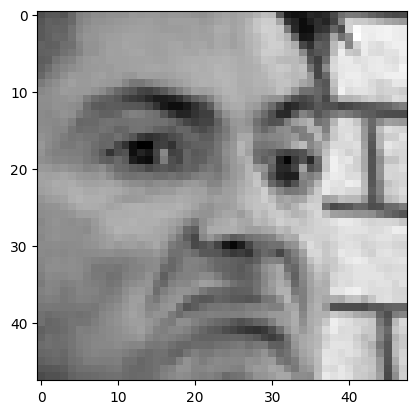

> testing image index: 389
> true emotion: disgust
> predicted emotion: surprise
1/1 [==============================] - 0s 17ms/step


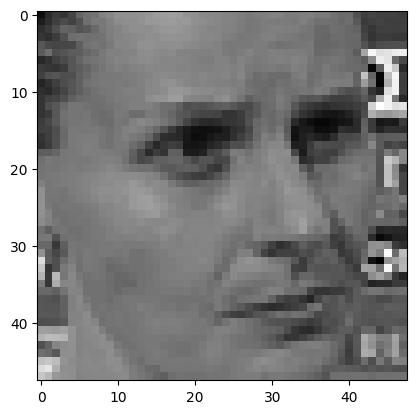

> testing image index: 284
> true emotion: sad
> predicted emotion: fear
1/1 [==============================] - 0s 19ms/step


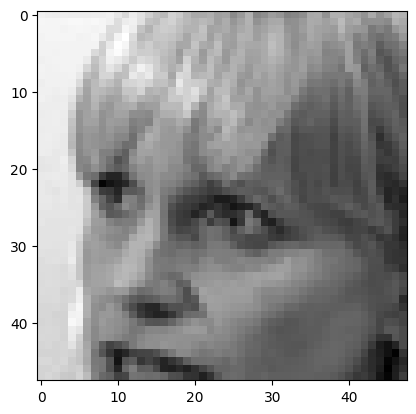

> testing image index: 918
> true emotion: sad
> predicted emotion: neutral
1/1 [==============================] - 0s 19ms/step


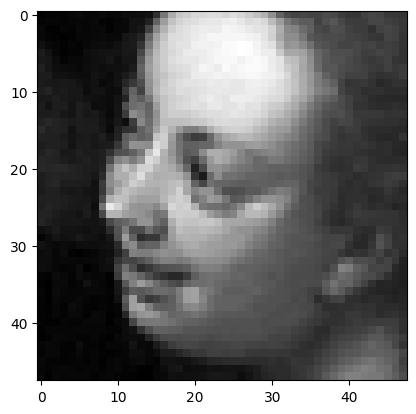

> testing image index: 2019
> true emotion: happy
> predicted emotion: sad
1/1 [==============================] - 0s 24ms/step


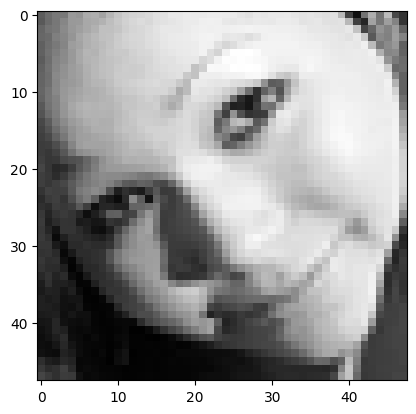

> testing image index: 750
> true emotion: happy
> predicted emotion: sad
1/1 [==============================] - 0s 17ms/step


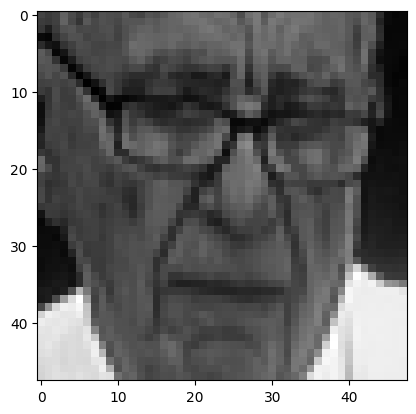

> testing image index: 2447
> true emotion: sad
> predicted emotion: neutral


In [35]:
# Get all indices where the predicted label does not match the true label
mismatch_indices = np.where(y_test_pred_label != y_test_label)[0]

# Randomly select 10 indices from the mismatched indices
if len(mismatch_indices) > 10:
    img_to_predict = np.random.choice(mismatch_indices, size=10, replace=False)
else:
    img_to_predict = mismatch_indices
# Loop through each index and use your predict_image function
for indx in img_to_predict:
    predict_image(indx)

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cm = confusion_matrix(y_test_label, y_test_pred_label,  normalize='true')
cm

array([[0.52034261, 0.00214133, 0.11134904, 0.07708779, 0.14132762,
        0.03640257, 0.11134904],
       [0.25      , 0.46428571, 0.05357143, 0.03571429, 0.10714286,
        0.03571429, 0.05357143],
       [0.12298387, 0.00201613, 0.46169355, 0.05846774, 0.15927419,
        0.07459677, 0.12096774],
       [0.03687151, 0.        , 0.02905028, 0.80223464, 0.0301676 ,
        0.0301676 , 0.07150838],
       [0.1194487 , 0.        , 0.13169985, 0.08575804, 0.43797856,
        0.03369066, 0.1914242 ],
       [0.03855422, 0.        , 0.05783133, 0.04819277, 0.01445783,
        0.78313253, 0.05783133],
       [0.10378913, 0.00164745, 0.08731466, 0.10873147, 0.11202636,
        0.0247117 , 0.56177924]])

In [38]:
import seaborn as sn

<Axes: >

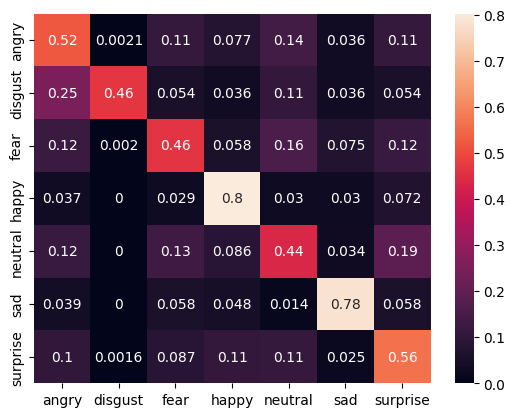

In [39]:
sn.heatmap(cm, annot=True,
           xticklabels=emotion_names, yticklabels=emotion_names)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer, Conv2D):
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=self.model.inputs,
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 17ms/step


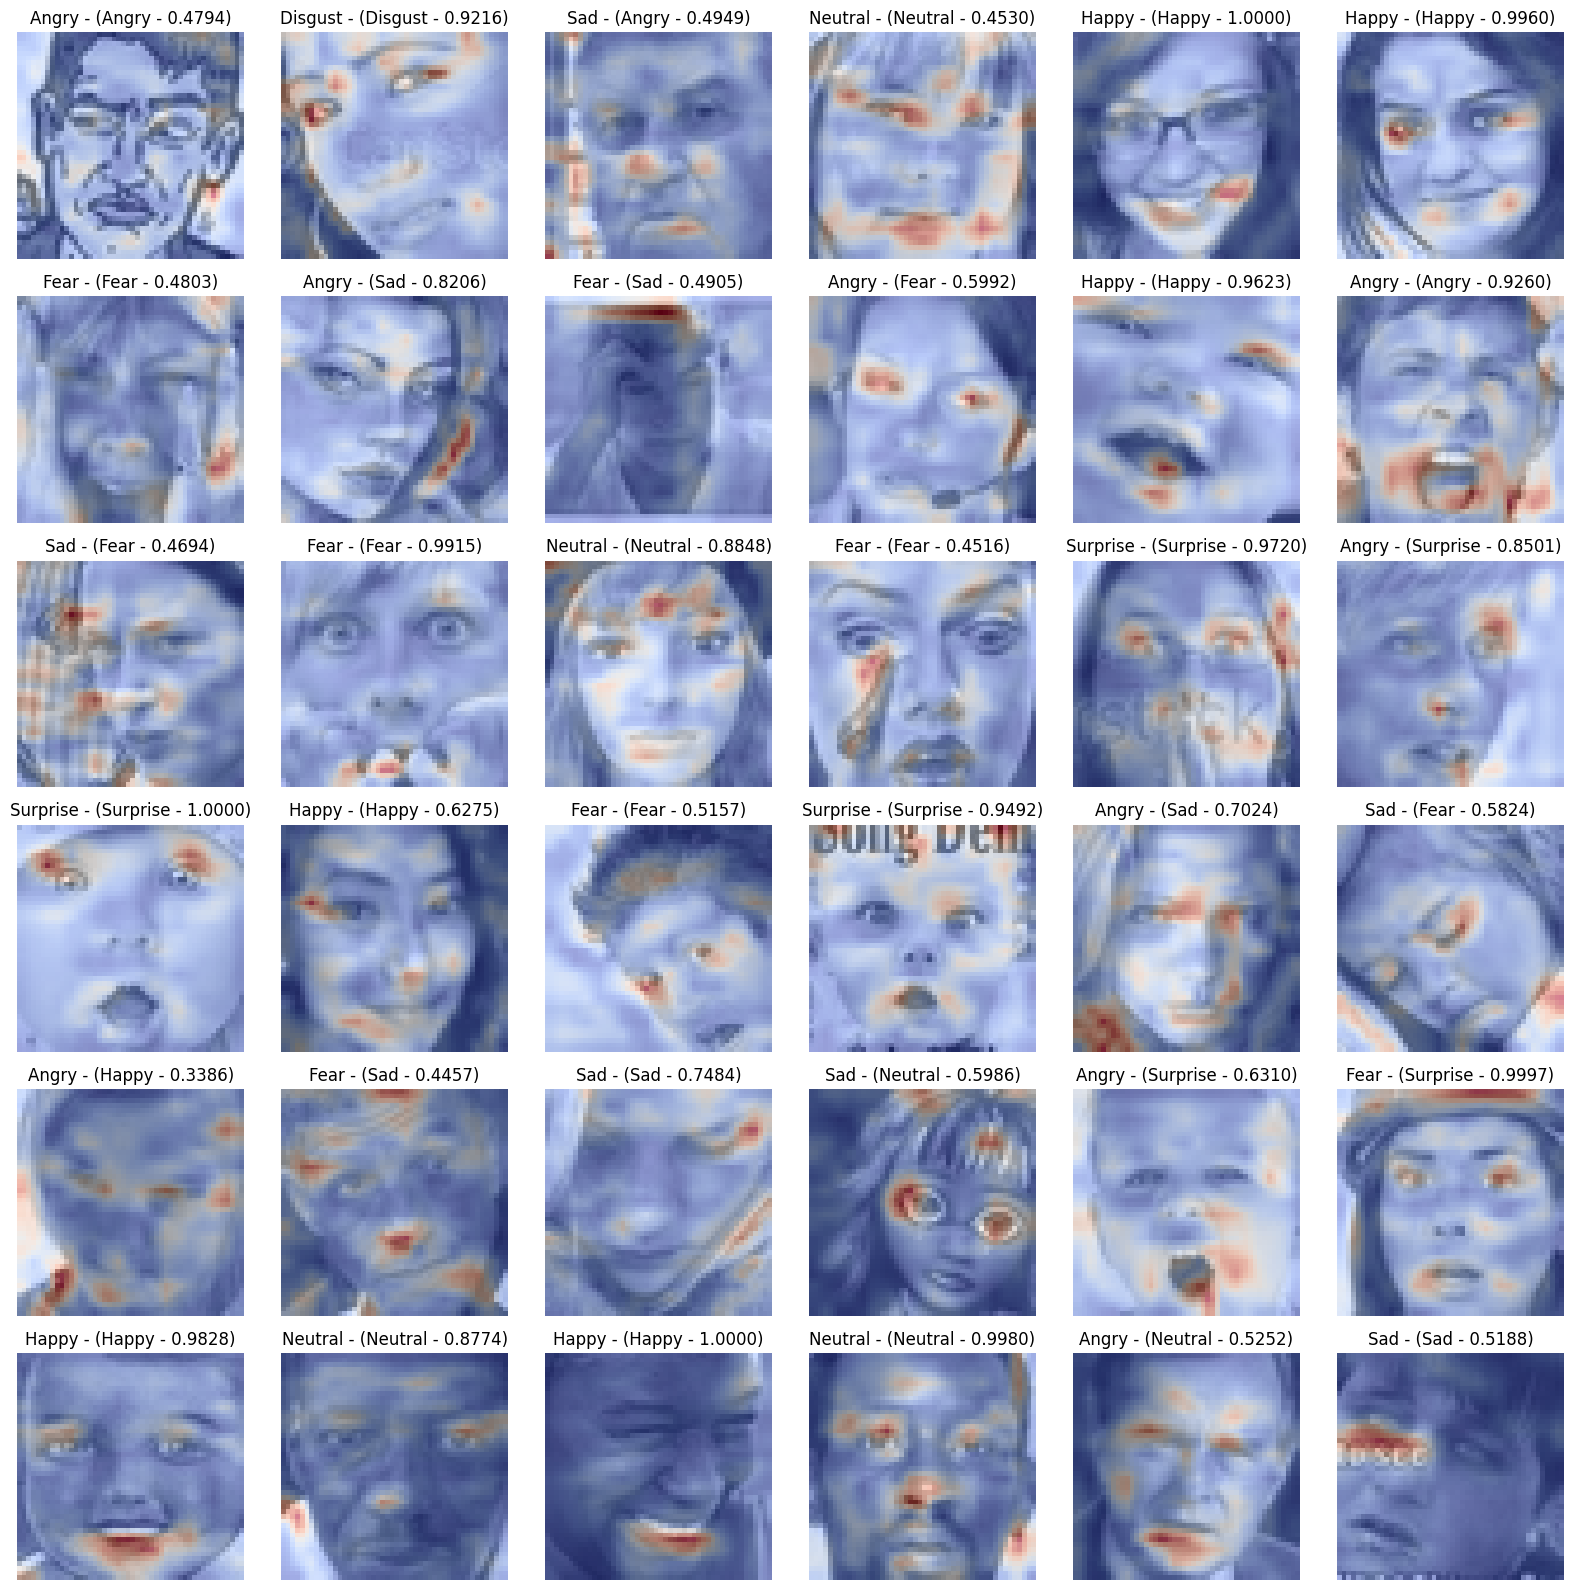

In [41]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = x_testing[i,:,:,0]
    p_dist = model.predict(img.reshape(1,48,48,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[y_test_label[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [42]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/baseline1.ipynb" --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/baseline1.ipynb to html
[NbConvertApp] Writing 1731651 bytes to /content/drive/MyDrive/Colab Notebooks/baseline1.html
